Importing Libraries

In [ ]:
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

Loading the data

In [ ]:
with open("/content/train_qa.txt", "rb") as fp:
    train_data =  pickle.load(fp)

In [ ]:
with open("/content/test_qa.txt", "rb") as fp:
    test_data =  pickle.load(fp)

In [ ]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [ ]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [ ]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [ ]:
''.join(train_data[0][2])

'no'

In [ ]:
vocab=set()

In [ ]:
all_data=train_data+test_data

In [ ]:
for story, question , answer in all_data:
  vocab=vocab.union(set(story))
  vocab=vocab.union(set(question))

In [ ]:
vocab.add('no')
vocab.add('yes')

In [ ]:
' '.join(vocab)

'. grabbed football bathroom Sandra in went to back Daniel got ? yes milk John put Is there kitchen the up hallway took Mary garden dropped apple office down moved journeyed picked travelled left discarded no bedroom'

In [ ]:
vocab_len= len(vocab)+1

In [ ]:
max_story_len = max([len(data[0]) for data in all_data])

In [ ]:
max_story_len

156

In [ ]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

Vectorising the DATA

In [ ]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
vocab_size=len(vocab)+1

In [ ]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [ ]:
tokenizer.word_index

{'.': 1,
 'grabbed': 2,
 'football': 3,
 'bathroom': 4,
 'sandra': 5,
 'in': 6,
 'went': 7,
 'to': 8,
 'back': 9,
 'daniel': 10,
 'got': 11,
 '?': 12,
 'yes': 13,
 'milk': 14,
 'john': 15,
 'put': 16,
 'is': 17,
 'there': 18,
 'kitchen': 19,
 'the': 20,
 'up': 21,
 'hallway': 22,
 'took': 23,
 'mary': 24,
 'garden': 25,
 'dropped': 26,
 'apple': 27,
 'office': 28,
 'down': 29,
 'moved': 30,
 'journeyed': 31,
 'picked': 32,
 'travelled': 33,
 'left': 34,
 'discarded': 35,
 'no': 36,
 'bedroom': 37}

In [ ]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [ ]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [ ]:
len(train_story_text)

10000

In [ ]:
len(train_story_seq)

10000

Functionalise Vectorization

In [ ]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):

    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []


    for story, query, answer in data:

        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]

        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)

        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1

        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.

    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [ ]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [ ]:
inputs_test

array([[ 0,  0,  0, ..., 20, 37,  1],
       [ 0,  0,  0, ..., 20, 25,  1],
       [ 0,  0,  0, ..., 20, 25,  1],
       ...,
       [ 0,  0,  0, ..., 20, 27,  1],
       [ 0,  0,  0, ..., 20, 25,  1],
       [ 0,  0,  0, ..., 27, 18,  1]], dtype=int32)

In [ ]:
queries_test

array([[17, 15,  6, 20, 19, 12],
       [17, 15,  6, 20, 19, 12],
       [17, 15,  6, 20, 25, 12],
       ...,
       [17, 24,  6, 20, 37, 12],
       [17,  5,  6, 20, 25, 12],
       [17, 24,  6, 20, 25, 12]], dtype=int32)

In [ ]:
answers_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 503.,   0.])

In [ ]:
tokenizer.word_index['yes']

13

In [ ]:
tokenizer.word_index['no']

36

Creating the model

In [ ]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

Input Encoder m

In [ ]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

Input Encoder c

In [ ]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

Question Encoder

In [ ]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

Encode the Sequences

In [ ]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [ ]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

Add this match matrix with the second input vector sequence

In [ ]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

Concatenate

In [ ]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [ ]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [ ]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)

In [ ]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [ ]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=16,
                    epochs=64,validation_data=([inputs_test, queries_test], answers_test))

In [ ]:
filename = 'chatbot_gdsc'
model.save(filename)

Evaluating the model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


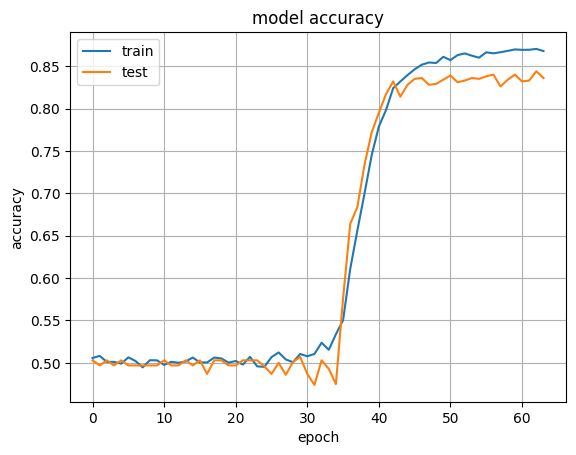

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()

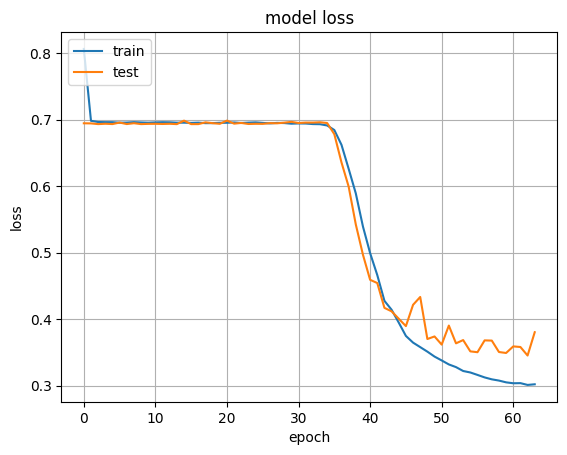

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluating on given test set

In [ ]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 2ms/step


In [ ]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [ ]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [ ]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [ ]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999903


Testing

In [ ]:
my_story="john travelled to bedroom . mary got apple"
my_story.split()

['john', 'travelled', 'to', 'bedroom', '.', 'mary', 'got', 'apple']

In [ ]:
my_question="Is john is in bedroom ?"
my_question.split()

['Is', 'john', 'is', 'in', 'bedroom', '?']

In [ ]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [ ]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [ ]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 20ms/step


In [ ]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9252402
